In [ ]:
import os
import numpy as np
from skimage import io
from skimage.transform import integral_image
from skimage.transform import resize
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import patches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#
TRUCKS_PATH = '/content/drive/MyDrive/Colab Notebooks/lab3/train/home'
NONTRUCKS_PATH = '/content/drive/MyDrive/Colab Notebooks/lab3/train/non_home'
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/lab3/test'
trucks_list_dir = os.listdir(TRUCKS_PATH)
non_trucks_list_dir = os.listdir(NONTRUCKS_PATH)
test_list_dir = os.listdir(TEST_PATH)
DETECTION_WINDOW_WIDTH = 150
DETECTION_WINDOW_HEIGHT = 150
RESIZE_WIDTH = 20
RESIZE_HEIGHT = 20
NUMBER_TOP_FEATURES = 100

In [ ]:
def read_images(path):
    """Read images from directory to list."""
    images = []
    list_dir = os.listdir(path)
    for file_name in list_dir:
        image = io.imread(path + '/' + file_name, as_gray=True)
        images.append(image)
    return images

In [ ]:
def extract_feature_values(img, feature_coords=None, feature_types=None):
    """Extract the haar feature for the current image."""
    ii = integral_image(img)
    values = haar_like_feature(ii, 0, 0, RESIZE_WIDTH, RESIZE_HEIGHT,
                               feature_type=feature_types,
                               feature_coord=feature_coords)
    return values

In [ ]:
def get_points(images):
    """Возвращает массив точек, в которых содержаться все возможные признаки."""
    points = []
    for image in images:
        points.append(extract_feature_values(image))
    points = np.array(points)  # массив точек данных со всеми признаками
    return points

In [ ]:
def get_best_n(classifier, points, number):
    """."""
    sorted_indexies = np.argsort(classifier.feature_importances_)[::-1]
    best_n_indexies = sorted_indexies[:number]

    # получаем список со значениями всех признаков и список с типами признаков
    feature_coords, feature_types = haar_like_feature_coord(RESIZE_WIDTH, RESIZE_HEIGHT)

    new_points = []
    for point in points:
        new_point = []
        for index in best_n_indexies:
            new_point.append(point[index])
        new_points.append(new_point)

    best_feature_coords = []
    for index in best_n_indexies:
        best_feature_coords.append(feature_coords[index])
    best_feature_coords = np.array(best_feature_coords, dtype=object)

    best_feature_types = []
    for index in best_n_indexies:
        best_feature_types.append(feature_types[index])
    best_feature_types = np.array(best_feature_types, dtype=object)

    return new_points, best_feature_coords, best_feature_types

In [ ]:
def train(object_path, nonobject_path):
    """."""
    trucks = read_images(object_path)
    non_trucks = read_images(nonobject_path)
    images = trucks + non_trucks

    points = get_points(images)
    labels = np.array(['truck'] * len(trucks) + ['non_truck'] * len(non_trucks))

    # классификатор, обученный на всех 78 тысячах признаках
    classifier = RandomForestClassifier(n_estimators=1000,
                                        max_depth=None,
                                        max_features=100,
                                        n_jobs=-1,
                                        random_state=0)
    classifier.fit(points, labels)

    new_points, best_feature_coords, best_feature_types = get_best_n(classifier, points, NUMBER_TOP_FEATURES)

    new_classifier = RandomForestClassifier(n_estimators=1000,
                                            max_depth=None,
                                            max_features=100,
                                            n_jobs=-1,
                                            random_state=0)
    new_classifier.fit(new_points, labels)
    return new_classifier, best_feature_coords, best_feature_types


In [ ]:
def test(classifier, test_path, best_feature_coords, best_feature_types):
    """."""
    test_images = read_images(test_path)
    _, axes = plt.subplots(1, len(test_images))
    axes = axes.flatten()
    for image, ax in zip(test_images, axes):
        n_steps_w = image.shape[1]  # ширина
        n_steps_h = image.shape[0]  # высота

        ax.imshow(image)
        for h in range(n_steps_h - DETECTION_WINDOW_HEIGHT):
            for w in range(n_steps_w - DETECTION_WINDOW_WIDTH):
                crop = test_images[0][h:h + DETECTION_WINDOW_HEIGHT, w:w + DETECTION_WINDOW_WIDTH]  # вырезаем часть
                crop = resize(crop, (RESIZE_WIDTH, RESIZE_HEIGHT), anti_aliasing=True)  # ресайзим до 20х20
                feature_values = extract_feature_values(crop, best_feature_coords,
                                                        best_feature_types)  # считаем для обрезка значение признаков
                predict = classifier.predict([feature_values])  # получаем предсказание
                if predict == 'truck':
                    draw_rectangle = patches.Rectangle((w, h), DETECTION_WINDOW_WIDTH, DETECTION_WINDOW_HEIGHT,
                                                       fill=False)
                    ax.add_patch(draw_rectangle)
    plt.show()

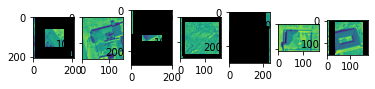

In [ ]:
classifier, best_feature_coords, best_feature_types = train(TRUCKS_PATH, NONTRUCKS_PATH)
test(classifier, TEST_PATH, best_feature_coords, best_feature_types)